In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
import scipy.stats 
ins = BrainSpan()

In [5]:
print (pd.__version__)
print (np.__version__)

0.23.4
1.15.4


In [3]:
DatDir = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/"
ProLGD = pd.read_excel(DatDir + "wigler2014ProLGD.xlsx")
ProLGD.shape

(391, 16)

In [4]:
ProLGD.columns.values

array(['familyId', 'location', 'variant', 'vcfVariant', 'inChild',
       'fromParent', 'effectGene', 'effectType', 'familyDescription',
       'CSHL', 'YALE', 'UW', 'IossifovWE2012', 'EichlerWE2012',
       'StateWE2012', 'EichlerTG2012'], dtype=object)

In [5]:
ProLGD = ProLGD[['familyId', 'location', 'variant', 'vcfVariant', 'inChild',
       'fromParent', 'effectGene', 'effectType', 'familyDescription']]
ProLGD.loc[ProLGD["effectGene"]=="MTHFS,ST20-MTHFS", "effectGene"] = "MTHFS"
ProLGD.loc[ProLGD["effectGene"]=="UGT1A10,UGT1A8,UGT1A9,UGT1A4,UGT1A5,UGT1A6,UGT1A7,UGT1A1,UGT1A3", "effectGene"] = "UGT1A1"
ProLGD.head(2)

,familyId,location,variant,vcfVariant,inChild,fromParent,effectGene,effectType,familyDescription
0,14320,3:127395222,sub(T->G),3:127395222:T:G,pF,NaN,ABTB1,noStart,pFsM
1,13585,12:109577550,ins(G),12:109577549:A:AG,pM,dad,ACACB,frame-shift,pMsF


In [6]:
SSC_LGD_GENES = set(ProLGD["effectGene"].values)
print(len(SSC_LGD_GENES))

352


In [7]:
Genes = {}
hand = open("../data/gencode.v19.chr_patch_hapl_scaff.annotation.gtf", 'rt')
GeneIDs = []
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "gene":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"].split(".")[0]
        Genes[gene_name] = GTFGene(gene_name, gene_id, strand)
        GeneIDs.append(gene_id)

In [8]:
GeneNames = set(Genes.keys())
SSC_LGD_GENES.difference(GeneNames)

set()

In [9]:
#subsetGTF("../data/gencode.v19.chr_patch_hapl_scaff.annotation.gtf", GeneNames, 
#          "../data/gencode.v19.SSC_LGD.gtf")

In [36]:
Genes = LoadGTF4FracIso("../data/gencode.v19.SSC_LGD.gtf")

In [37]:
ProLGD = LoadVar4FracIso(ProLGD, Genes)

In [38]:
def ExonsList2ENSExonID(row):
    ExonList = row["Exons"]
    ExonList = [exon.split(".")[0] for exon in ExonList]
    return ";".join(ExonList)
def ExonsList2ENSTransID(row):
    ExonList = row["Transcripts"]
    ExonList = [exon.split(".")[0] for exon in ExonList]
    return ";".join(ExonList)
ProLGD["ENSExonIDs"] = ProLGD.apply(lambda row: ExonsList2ENSExonID(row), axis=1)
ProLGD["ENSTransIDs"] = ProLGD.apply(lambda row: ExonsList2ENSTransID(row), axis=1)

In [39]:
ProLGD[ProLGD['familyId']==13839]

,familyId,location,variant,vcfVariant,inChild,fromParent,effectGene,effectType,familyDescription,Exons,Transcripts,ENSExonIDs,ENSTransIDs
235,13839,1:145589355,ins(CA),1:145589354:C:CCA,pM,NaN,NUDT17,frame-shift,pMsF,[ENSE00001905197.1],[ENST00000334513],ENSE00001905197,ENST00000334513


In [40]:
exon_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.addExonID.csv", delimiter = ",")
exon_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")

In [41]:
exon_exp_row.head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317,TSPAN6_1
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,108,TSPAN6_2
2,3,1086864,ENSG00000000003,TSPAN6,7105.0,99887481,99887565,84,84,TSPAN6_3
3,4,1086864,ENSG00000000003,TSPAN6,7105.0,99888401,99888536,135,135,TSPAN6_4
4,5,1086864,ENSG00000000003,TSPAN6,7105.0,99888927,99889026,99,99,TSPAN6_5


In [42]:
def searchExon(ensembl_gene_id, Chr, Pos, Ref, Alt, ExonRow, ExonCol):
    Pos, LenV = int(Pos), len(Ref)-len(Alt)
    ExonRow = ExonRow[ExonRow["ensembl_gene_id"]==ensembl_gene_id]
    if ExonRow.shape[0] == 0:
        return -1, -1
    for i, row in ExonRow.iterrows():
        row_num, start, end = row["row_num"],int(row["start"]),int(row["end"])
        #print(Pos, start, end)
        if Pos > start -3 and Pos < end + 3:
            #return row_num
            return "{}:{}".format(ensembl_gene_id, start), row_num
        elif LenV > 0: # a delition may span a splice site
            if (Pos < start-3 and Pos + LenV > start ) or (Pos < end and Pos + LenV > end +3):
                #return row_num
                return "{}:{}".format(ensembl_gene_id, start), row_num
    return -2, -2

MisLeadingENSG = []
ProLGD["BrainSpanExonID"] = "NA"
ProLGD["BrainSpanExonRowNum"] = "NA"
for i, row in ProLGD.iterrows():
    famid, gene, (Chr, Pos, Ref, Alt) = row["familyId"], row["effectGene"], row["vcfVariant"].split(":")
    ProLGD.at[i, "ENSGID"] = Genes[gene].GeneID
    exonId1, exonId2 = searchExon(Genes[gene].GeneID, Chr, Pos, Ref, Alt, exon_exp_row, exon_exp_col)
    ProLGD.at[i, "BrainSpanExonID"] = exonId1
    ProLGD.at[i, "BrainSpanExonRowNum"] = exonId2
    if len(Ref) == len(Alt):
        ProLGD.at[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos))
    else:
        ProLGD.at[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos)+1)
    if exonId1 == -1:
        MisLeadingENSG.append((gene))
        print("gene not find", famid, gene, Genes[gene].GeneID)
    elif exonId1 == -2:
        print("exon not find", famid, gene, Genes[gene].GeneID)

gene not find 12563 CCPG1 ENSG00000260916
gene not find 12681 GRIN2B ENSG00000273079
gene not find 12547 GRIN2B ENSG00000273079
gene not find 11691 GRIN2B ENSG00000273079
gene not find 13861 KIR2DL2 ENSG00000263175
gene not find 12840 TM4SF19 ENSG00000273331
exon not find 13913 ZNF853 ENSG00000236609


In [43]:
NewENSG = {}
for g in MisLeadingENSG:
    ExonRow = exon_exp_row[exon_exp_row["gene_symbol"]==g]
    if ExonRow.head(1).shape[0] == 1:
        #display(ExonRow.head(1))
        NewENSG[g] = ExonRow.head(1)["ensembl_gene_id"].values[0]
        Genes[g].GeneID = ExonRow.head(1)["ensembl_gene_id"].values[0]
        print(Genes[g].GeneID)
    else:
        print(g)

CCPG1
ENSG00000150086
ENSG00000150086
ENSG00000150086
KIR2DL2
ENSG00000145107


In [44]:
ProLGD.columns

Index(['familyId', 'location', 'variant', 'vcfVariant', 'inChild',
       'fromParent', 'effectGene', 'effectType', 'familyDescription', 'Exons',
       'Transcripts', 'ENSExonIDs', 'ENSTransIDs', 'BrainSpanExonID',
       'BrainSpanExonRowNum', 'ENSGID', 'KEY'],
      dtype='object')

In [45]:
ProLGD = ProLGD[['KEY', 'familyId', 'location', 'variant', 'vcfVariant', 'inChild',
       'fromParent', 'ENSGID', 'effectGene', 'effectType', 'familyDescription', 
        'ENSExonIDs', 'ENSTransIDs', 'BrainSpanExonID', "BrainSpanExonRowNum"]]
ProLGD.head()

,KEY,familyId,location,variant,vcfVariant,inChild,fromParent,ENSGID,effectGene,effectType,familyDescription,ENSExonIDs,ENSTransIDs,BrainSpanExonID,BrainSpanExonRowNum
0,14320-3:127395222,14320,3:127395222,sub(T->G),3:127395222:T:G,pF,NaN,ENSG00000114626,ABTB1,noStart,pFsM,ENSE00003537266;ENSE00003616869,ENST00000393363;ENST00000232744;ENST0000046813...,ENSG00000114626:127394328,65963
1,13585-12:109577550,13585,12:109577550,ins(G),12:109577549:A:AG,pM,dad,ENSG00000076555,ACACB,frame-shift,pMsF,ENSE00002307745;ENSE00002274661,ENST00000539864;ENST00000377854;ENST0000037784...,ENSG00000076555:109577201,23792
2,13702-3:58491005,13702,3:58491005,del(1),3:58491004:CA:C,pM,NaN,ENSG00000168306,ACOX2,frame-shift,pMsM,ENSE00003509301,ENST00000302819;ENST00000459701,ENSG00000168306:58490862,171602
3,12561-20:3655475,12561,20:3655475,sub(G->A),20:3655475:G:A,pM,NaN,ENSG00000149451,ADAM33,nonsense,pMsF,ENSE00003214806,ENST00000350009;ENST00000379861;ENST00000356518,ENSG00000149451:3654958,131960
4,13994-19:8645778,13994,19:8645778,del(9),19:8645777:CTAGTGGCCA:C,pM,NaN,ENSG00000142303,ADAMTS10,noEnd,pM,ENSE00003109980;ENSE00001316649,ENST00000595838;ENST00000597188;ENST00000270328,ENSG00000142303:8645125,118537


In [46]:
ProLGD[ProLGD["ENSExonIDs"]==""].shape

(5, 15)

In [47]:
for i, row in ProLGD.iterrows():
    famid, gene, (Chr, Pos, Ref, Alt) = row["familyId"], row["effectGene"], row["vcfVariant"].split(":")
    nlej, isle,  islej = isLEJ(gene, Pos, Ref, Alt, Genes)
    #ProLGD.at[i, "NLEJ"] = nlej
    #ProLGD.at[i, "isLE"] = isle
    #ProLGD.at[i, "isLEJ"] = islej
    if (isle == "T") or (islej == "T"): 
        #print(isle, islej)
        isNMD = "True"
    else:
        #print(isle, islej)
        isNMD = "False"
    ProLGD.at[i, "isNMD"] = isNMD

In [48]:
ProLGD.head(10)

,KEY,familyId,location,variant,vcfVariant,inChild,fromParent,ENSGID,effectGene,effectType,familyDescription,ENSExonIDs,ENSTransIDs,BrainSpanExonID,BrainSpanExonRowNum,isNMD
0,14320-3:127395222,14320,3:127395222,sub(T->G),3:127395222:T:G,pF,NaN,ENSG00000114626,ABTB1,noStart,pFsM,ENSE00003537266;ENSE00003616869,ENST00000393363;ENST00000232744;ENST0000046813...,ENSG00000114626:127394328,65963,False
1,13585-12:109577550,13585,12:109577550,ins(G),12:109577549:A:AG,pM,dad,ENSG00000076555,ACACB,frame-shift,pMsF,ENSE00002307745;ENSE00002274661,ENST00000539864;ENST00000377854;ENST0000037784...,ENSG00000076555:109577201,23792,True
2,13702-3:58491005,13702,3:58491005,del(1),3:58491004:CA:C,pM,NaN,ENSG00000168306,ACOX2,frame-shift,pMsM,ENSE00003509301,ENST00000302819;ENST00000459701,ENSG00000168306:58490862,171602,True
3,12561-20:3655475,12561,20:3655475,sub(G->A),20:3655475:G:A,pM,NaN,ENSG00000149451,ADAM33,nonsense,pMsF,ENSE00003214806,ENST00000350009;ENST00000379861;ENST00000356518,ENSG00000149451:3654958,131960,False
4,13994-19:8645778,13994,19:8645778,del(9),19:8645777:CTAGTGGCCA:C,pM,NaN,ENSG00000142303,ADAMTS10,noEnd,pM,ENSE00003109980;ENSE00001316649,ENST00000595838;ENST00000597188;ENST00000270328,ENSG00000142303:8645125,118537,True
5,14490-3:64547409,14490,3:64547409,sub(G->A),3:64547409:G:A,pM,NaN,ENSG00000163638,ADAMTS9,nonsense,pMsF,ENSE00003689376,ENST00000498707;ENST00000295903;ENST00000481060,ENSG00000163638:64547253,157152,False
6,11717-16:4165337,11717,16:4165337,del(1),16:4165336:CT:C,pM,NaN,ENSG00000162104,ADCY9,frame-shift,pMsF,ENSE00001062629,ENST00000294016,ENSG00000162104:4163750,152243,False
7,13545-20:49509095,13545,20:49509095,ins(T),20:49509094:G:GT,pM,NaN,ENSG00000101126,ADNP,frame-shift,pM,ENSE00001455631;ENSE00001523629,ENST00000396029;ENST00000371602;ENST0000034901...,ENSG00000101126:49505584,41150,True
8,12130-20:49510028,12130,20:49510028,del(2),20:49510027:CTT:C,pF,NaN,ENSG00000101126,ADNP,frame-shift,pF,ENSE00001455631;ENSE00001523629,ENST00000396029;ENST00000371602;ENST0000034901...,ENSG00000101126:49505584,41150,True
9,12246-4:74357772,12246,4:74357772,sub(C->T),4:74357772:C:T,pM,NaN,ENSG00000079557,AFM,nonsense,pMsF,ENSE00000721786,ENST00000226355,ENSG00000079557:74357588,26077,False


In [49]:
ProLGD.to_csv("lgd-jw.csv", index=False)

In [51]:
ProLGD[ProLGD['familyId']==11145]

,KEY,familyId,location,variant,vcfVariant,inChild,fromParent,ENSGID,effectGene,effectType,familyDescription,ENSExonIDs,ENSTransIDs,BrainSpanExonID,BrainSpanExonRowNum,isNMD
178,11145-11:118344387,11145,11:118344387,del(1),11:118344386:TG:T,pM,NaN,ENSG00000118058,KMT2A,frame-shift,pM,ENSE00002704839,ENST00000354520;ENST00000534358;ENST0000053190...,ENSG00000118058:118342376,72511,False


In [29]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv("./brainspan/exon_col_meta.csv")
cds_dict = loaddict()
bp_exon_row_meta = pd.read_csv("./brainspan/rows_metadata.csv")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta = MakeExonID(bp_exon_row_meta)
bp_exon_row_meta.head(2)
display(bp_exon_row_meta.head(2))
display(bp_exon_col_meta.head(2))

2400

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2
0,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,82,THSD7A_1
1,1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,THSD7A_2


,Unnamed: 0,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,Period,Stage,Description
0,0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip,2A,2,Early prenatal
1,1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex,2A,2,Early prenatal


In [276]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
#print(Jiayao_features.columns)
Jiayao_features = Jiayao_features[["KEY", "ExonID"]]
Jiayao_features.head(2)

,KEY,ExonID
0,13545-20:49509095,41150
1,12130-20:49510028,41150


In [280]:
row_num2start = {}
for i, row in bp_exon_row_meta.iterrows():
    new_id = "%s:%d" %(row["ensembl_gene_id"], row["start"])
    row_num2start[row["row_num"]] = new_id

In [284]:
Jiayao_features["ID2"] = Jiayao_features.apply(lambda row: row_num2start[row["ExonID"]], axis=1)
Jiayao_features.to_csv("../data/RecLGD2BrainSpanExonID.txt", index=False, sep="\t")

In [9]:
EXON_EXP_RPKM = pd.read_csv("./brainspan/qn.exons_matrix.csv", header=None)
EXON_EXP_RPKM.head(2)

,0,1,2,3,4,5,6,7,8,9,...,515,516,517,518,519,520,521,522,523,524
0,1249,13.981005,8.395309,2.331361,9.548689,13.077358,4.957344,11.519273,8.687774,8.699095,...,1.683465,1.528594,2.038370,3.015371,2.237213,2.333633,3.401376,1.251418,2.433152,4.952924
1,1250,13.693688,4.080420,1.455547,10.199496,11.281002,4.150340,14.074131,10.813428,8.187593,...,0.000000,0.452619,1.078534,1.501325,0.878050,1.277496,0.737068,1.999100,3.102934,0.000000


In [30]:
Stage2Idx = {}
for stage in Stages:
    tmp = bp_exon_col_meta[bp_exon_col_meta["Period"]==stage]
    Stage2Idx[stage]=tmp["column_num"].values

In [153]:
exonid2cds = pd.read_csv("../data/Andy-brainspan/brainspan_exon_cds.tsv", delimiter="\t")
exonid2cds.head(2)
exonid2cds = dict(zip(exonid2cds["exon_id"].values, exonid2cds["cds_len"].values))

In [31]:
ExonID2EXP_mean = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx)

In [56]:
ExonID2EXP_median = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx, stat="median")

In [64]:
ExonID2EXP_log2 = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx, stat="mean", log2=True)

In [80]:
ExonID2EXP_log2_median = GetExonTimeExp(EXON_EXP_RPKM, Stage2Idx, stat="median", log2=True)

In [35]:
VarFile = pd.read_excel("./data/ProLGD_wilger2014_predicted.July20.xlsx",index=False)
VarFile.head(2)

,familyId,location,variant,vcfVariant,inChild,fromParent,effectGene,effectType,familyDescription,ExonID,Gender,VIQ,NVIQ
0,13545,20:49509095,ins(T),20:49509094:G:GT,pM,NaN,ADNP,frame-shift,pM,41150,M,23,38
1,12130,20:49510028,del(2),20:49510027:CTT:C,pF,NaN,ADNP,frame-shift,pF,41150,F,62,55


In [253]:
exonPartition = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/Andy-brainspan/PartitionExons_v2_byq.csv")

AndyGeneSet = set([x.split("_")[0] for x in exonPartition["exon_id"].values])
ExonID2Part = dict(zip(exonPartition["exon_id"].values, exonPartition["group_id"].values))
#PredictedLGDGeneSet.difference(AndyGeneSet)
#AndyGeneSet.difference(PredictedLGDGeneSet)
exonPartition.head(2)
Exon_Coord = pd.read_csv("../data/Andy-brainspan/BrainSpan_RNAseq_Gencode_Exon_Coordinates.flat", 
    delimiter="\t")
Exon_Coord.head(2)
Exon_Coord["length"] = Exon_Coord["end_post"] - Exon_Coord["start_post"]
ExonID2Length = dict(zip(Exon_Coord["exon_id"].values, Exon_Coord["length"].values))
ExonID2Length = exonid2cds

In [177]:
Genes = list(AndyGeneSet)
expdict_gene = {}
ExonPool = PoolTheExons2(ins, ExonID2EXP_mean, VarFile, Genes, bp_exon_row_meta, exonid2cds,
                       minLog2RPKMplus1Cut = 1)

In [234]:
#ExonID2EXP_median
ExonPool2 = PoolTheExons2(ins, ExonID2EXP_median, VarFile, Genes, bp_exon_row_meta, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

/Users/jiayao/Work/BrainDisorders/src/utils.py:3300: RuntimeWarning: invalid value encountered in double_scalars
  self.relbias = np.mean(self.exonExp[:6]) / np.mean(self.exonExp[6:])
/Users/jiayao/Work/BrainDisorders/src/utils.py:3300: RuntimeWarning: divide by zero encountered in double_scalars
  self.relbias = np.mean(self.exonExp[:6]) / np.mean(self.exonExp[6:])


In [228]:
#ExonID2EXP_log2
ExonPool3 = PoolTheExons2(ins, ExonID2EXP_log2, VarFile, Genes, bp_exon_row_meta, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

In [221]:
#ExonID2EXP_log2_median
ExonPool4 = PoolTheExons2(ins, ExonID2EXP_log2_median, VarFile, Genes, bp_exon_row_meta, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

In [240]:
BinsAndy = BinExon_UseAndyBin(ExonPool3, ExonID2Part)
BinsJW = BinExon(ExonPool3)

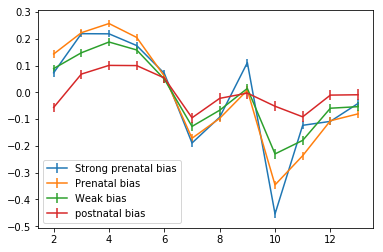

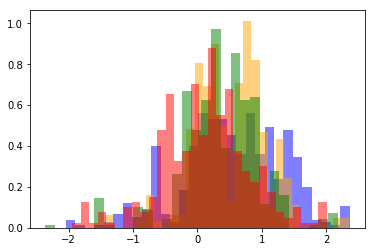

In [241]:
PlotExonBins(BinsAndy)
PlotExonHist(BinsAndy)

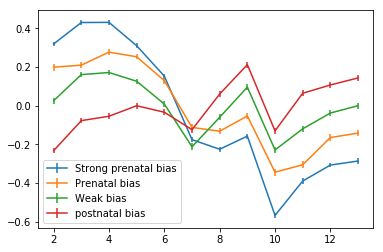

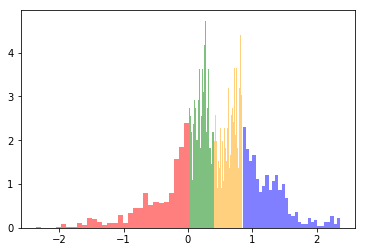

440
440
440
441


In [242]:
PlotExonBins(BinsJW)
PlotExonHist(BinsJW)
for XX in BinsJW:
    print(len(XX))

36 96143
19 77731
26 88341
36 98604


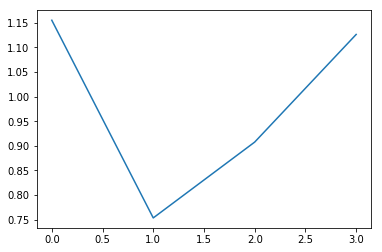

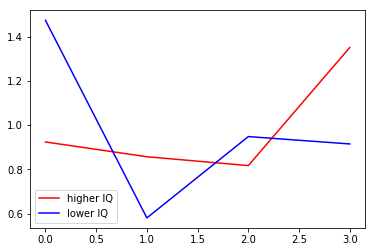

In [243]:
ExonBinsBurden(BinsAndy)

35 81072
29 105189
24 83556
29 91002


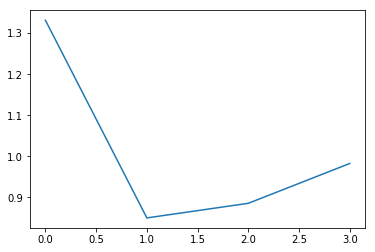

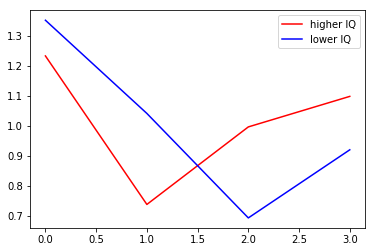

In [244]:
ExonBinsBurden(BinsJW)

In [249]:
Andy_period = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/Andy-brainspan/period-andys-method.csv")
Andy_period.head(2)

,ROW,ENS.GENE,GENE.SYMBOL,ENTREZ,START,END,KEY,PERIOD.1,PERIOD.2,PERIOD.3,...,PERIOD.6,PERIOD.7,PERIOD.8,PERIOD.9,PERIOD.10,PERIOD.11,PERIOD.12,PRENATAL,POSTNATAL,ALL
0,1,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,ENSG00000000003-99883666,23.001009,11.027659,9.982415,...,19.570779,12.423208,4.207665,12.099316,9.095215,5.175308,4.187070,13.289970,7.222306,9.966650
1,2,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,ENSG00000000003-99885755,50.271498,19.503891,17.471636,...,33.595716,22.045745,7.840054,14.901883,11.759338,7.836597,5.845617,24.221006,10.469125,16.688965


In [254]:
Predicted_Andy_Period = Andy_period[Andy_period["GENE.SYMBOL"].isin(AndyGeneSet)]
Predicted_Andy_Period.shape

(2199, 22)

In [255]:
Predicted_Andy_Period = MakeExonID(Predicted_Andy_Period)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


223300

In [256]:
Predicted_Andy_Period.head(2)

,ROW,ENS.GENE,GENE.SYMBOL,ENTREZ,START,END,KEY,PERIOD.1,PERIOD.2,PERIOD.3,...,PERIOD.7,PERIOD.8,PERIOD.9,PERIOD.10,PERIOD.11,PERIOD.12,PRENATAL,POSTNATAL,ALL,EXONID2
1248,1249,ENSG00000005108,THSD7A,221981.0,11410063,11415505,ENSG00000005108-11410063,7.000226,12.71537,8.057586,...,4.971328,4.202400,1.962977,4.476625,2.042213,2.354877,6.805844,3.011648,4.727725,THSD7A_1
1249,1250,ENSG00000005108,THSD7A,221981.0,11416196,11416284,ENSG00000005108-11416196,7.979306,13.07255,8.744875,...,2.775317,4.028767,0.324124,4.023622,2.001689,1.565880,6.626785,2.164720,4.182868,THSD7A_2


In [262]:
ExonPoolAndy = PoolTheExons3(ins, VarFile, Genes, Predicted_Andy_Period, ExonID2Length,
                       minLog2RPKMplus1Cut = 1)

In [263]:
BinsAndy = BinExon_UseAndyBin(ExonPoolAndy, ExonID2Part)
BinsJW = BinExon(ExonPoolAndy)

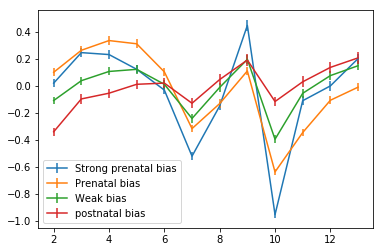

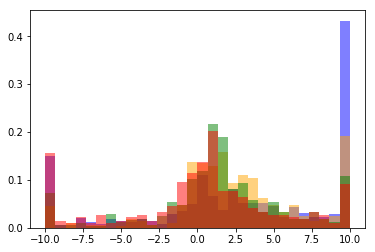

In [264]:
PlotExonBins(BinsAndy)
PlotExonHist(BinsAndy)

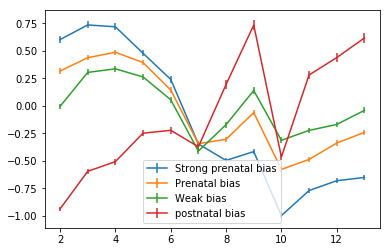

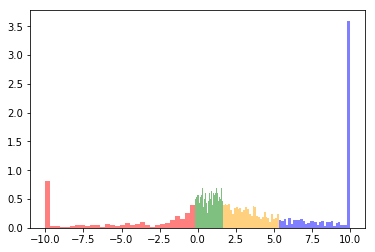

453
453
453
455


In [265]:
PlotExonBins(BinsJW)
PlotExonHist(BinsJW)
for XX in BinsJW:
    print(len(XX))

36 96537
19 78736
26 89876
37 103125


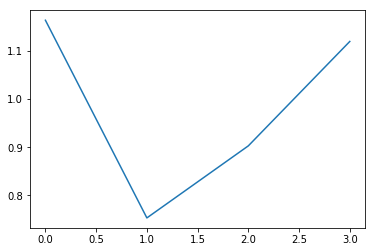

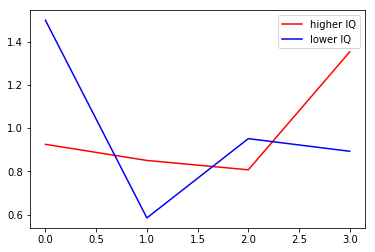

49 103391
17 95870
22 80157
30 88856


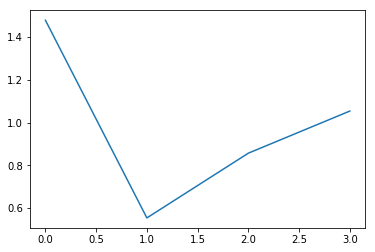

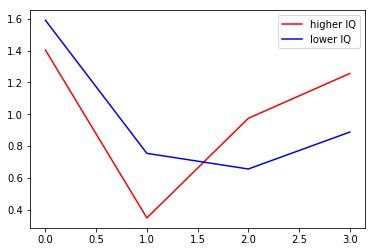

In [268]:
ExonBinsBurden(BinsAndy)
ExonBinsBurden(BinsJW)